# <span style = "background-color: #FFDDDD"> 이미지 어디까지 우려볼까?</span>

⭐️ CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?	CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.  
⭐️ 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?	각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점을 서술하였음  
⭐️ 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?	기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.

---
## <span style = "background-color: #FFFFDD"> 🐶 Environment Setting</span>

### <span style = "background-color: #F0E9FF"> 1. Import libraries & packages </span>

In [1]:
# dataset path
import os

# data array
import numpy as np

#
#from PIL import Image

# augmentation
import albumentations as album

# visualization
import matplotlib.pyplot as plt

# machine learning
import tensorflow as tf
import tensorflow.keras as keras

# dataset load
import tensorflow_datasets as tfds

2024-07-03 05:49:10.088509: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-03 05:49:10.152824: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### <span style = "background-color: #F0E9FF"> 2. Define constants</span>

In [2]:
# image data configurations
NUM_CLASSES = 120
IMG_SIZE = 224    # resized

In [3]:
# augmentation style option
NONE = 0
BASIC = 1
CUTMIX = 2
MIXUP = 3

In [4]:
# model training configurations
BATCH_SIZE = 8
EPOCHS = 20

### <span style = "background-color: #F0E9FF"> 3. Define frequently used methods</span>

In [5]:
DIVIDER_LENGTH = 80

def print_single_divider(length = DIVIDER_LENGTH):
    print("-" * DIVIDER_LENGTH)

def print_double_divider(length = DIVIDER_LENGTH):
    print("=" * DIVIDER_LENGTH)

### <span style = "background-color: #F0E9FF"> 4. Check GPU settings</span>

In [6]:
tf.config.list_physical_devices('GPU')

2024-07-03 05:49:33.101263: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-03 05:49:33.110475: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-03 05:49:33.110512: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---
## <span style = "background-color: #FFFFDD"> 🐶 Data Preparation</span>

### <span style = "background-color: #F0E9FF"> 1. Load dataset</span>

In [7]:
(ds_train, ds_test), ds_info = tfds.load("stanford_dogs",
                                         split=["train", "test"],
                                         as_supervised=True,
                                         shuffle_files=True,
                                         with_info=True,)

print("> The dataset has been loaded successfully!")

INFO:absl:Load dataset info from /root/tensorflow_datasets/stanford_dogs/0.2.0
INFO:absl:Reusing dataset stanford_dogs (/root/tensorflow_datasets/stanford_dogs/0.2.0)
INFO:absl:Creating a tf.data.Dataset reading 4 files located in folders: /root/tensorflow_datasets/stanford_dogs/0.2.0.
2024-07-03 05:49:33.222320: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-03 05:49:33.222386: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-03 05:49:33.222402: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-03 05:

> The dataset has been loaded successfully!


### <span style = "background-color: #F0E9FF"> 2. Preview data</span>

**2-1. Check dataset information** 

In [8]:
# check the dataset feature information
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
    }),
})


In [9]:
# check the number of train/test data samples
print(">>> The number of train data samples : ", tf.data.experimental.cardinality(ds_train))
print(">>> The number of test data samples  : ", tf.data.experimental.cardinality(ds_test))

>>> The number of train data samples :  tf.Tensor(12000, shape=(), dtype=int64)
>>> The number of test data samples  :  tf.Tensor(8580, shape=(), dtype=int64)


In [10]:
# check the label information
print(">>> The number of labels             : ", ds_info.features["label"].num_classes)
print(">>> List of labels                   : ", ds_info.features["label"].names)

# reset constants
NUM_CLASSES = ds_info.features["label"].num_classes

>>> The number of labels             :  120
>>> List of labels                   :  ['n02085620-chihuahua', 'n02085782-japanese_spaniel', 'n02085936-maltese_dog', 'n02086079-pekinese', 'n02086240-shih-tzu', 'n02086646-blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-rhodesian_ridgeback', 'n02088094-afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-walker_hound', 'n02089973-english_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-irish_wolfhound', 'n02091032-italian_greyhound', 'n02091134-whippet', 'n02091244-ibizan_hound', 'n02091467-norwegian_elkhound', 'n02091635-otterhound', 'n02091831-saluki', 'n02092002-scottish_deerhound', 'n02092339-weimaraner', 'n02093256-staffordshire_bullterrier', 'n02093428-american_staffordshire_terrier', 'n02093647-bedlington_terrier', 'n02093754-border_terrier', 'n02093859-kerry_blue_terrier', 'n02093991-irish_terrie

**2-2. Preview image data samples**

2024-07-03 05:49:35.321919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


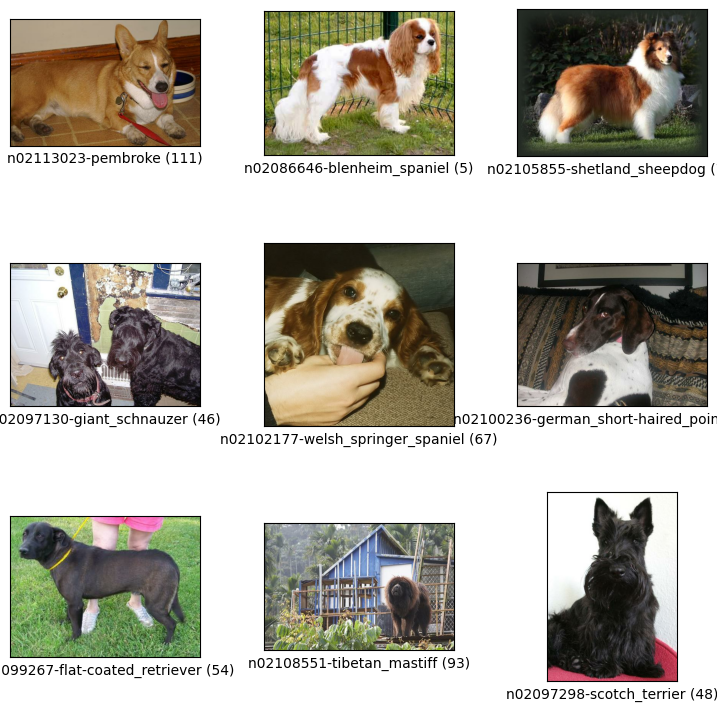

/tmp/ipykernel_265398/3432296509.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  preview_train.show()


In [11]:
preview_train = tfds.show_examples(ds_train, ds_info)
preview_train.show()

2024-07-03 05:49:36.058528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


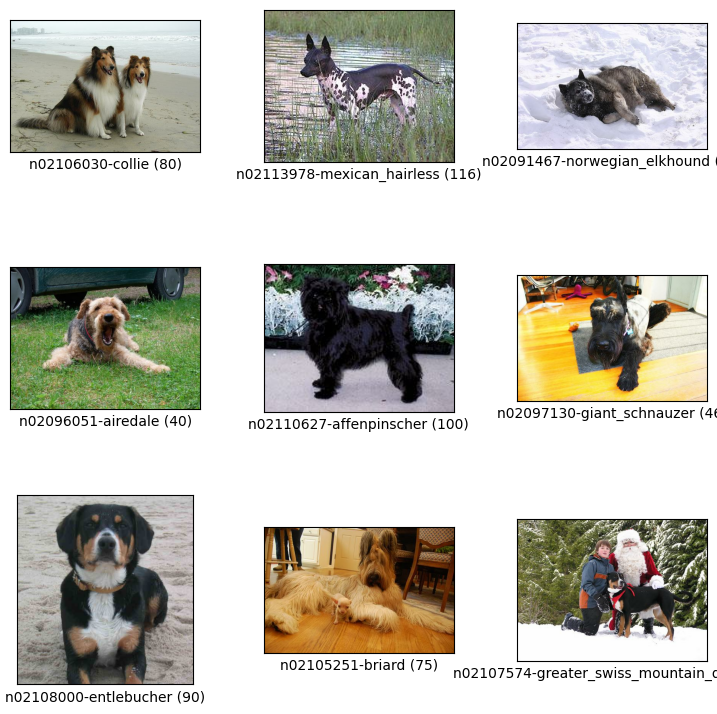

/tmp/ipykernel_265398/1412223897.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  preview_test.show()


In [12]:
preview_test = tfds.show_examples(ds_test, ds_info)
preview_test.show()

# train data와 test data는 동일한 데이터 샘플들을 일정 비율로 나눈 것이므로,
# 굳이 preview_train, preview_test로 나누어 두 번 확인할 필요는 없다.
# 하지만 귀여운 것은 두 번 보면 더 좋으니까 train/test 를 핑계로 굳이 두 번 봐야지 :D

### <span style = "background-color: #F0E9FF"> 3. Pre-processing & Augmentation</span>

**3-1. Define basic pre-process methods (resize, normalization)**

In [13]:
def resize_img(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image, label

In [14]:
def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.    # normalizes as `uint8` -> `float32`
    return image, label

In [15]:
def preprocess_img(image, label):
    image, label = resize_img(image, label)
    image, label = normalize_img(image, label)
    
    return image, label

**3-2. Define basic augmentation method (flip, brightness)**

In [16]:
def augment_basic(image,label):
    # horizontal flip (random)
    image = tf.image.random_flip_left_right(image)
    
    # brightness adjust (random)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)    # normalizes adjusted value
    
    return image, label

**3-3. Define CutMix augmentation method**

In [17]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

In [18]:
# cut-out and mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get cropped pieces from image_a & image_b
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    
    # merge cropped pieces
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [19]:
# mix two labels
def mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=NUM_CLASSES):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get mix ratio
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    # calculate mixed label by ratio
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b

    return mixed_label

In [20]:
def augment_cutmix(image, label, prob=1.0, batch_size=BATCH_SIZE, img_size=IMG_SIZE, num_classes=NUM_CLASSES):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        # get image_a sequentially
        image_a = image[i]
        label_a = label[i]
        
        # pick image_b randomly
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        
        # cutmix augmentation
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

**3-4. Define MixUp augmentation method**

In [21]:
# function for mixup
def mixup_2_images_labels(image_a, image_b, label_a, label_b, num_classes=NUM_CLASSES):
    ratio = tf.random.uniform([], 0, 1)
    
    # mix images by ratio
    mixed_image= (1-ratio)*image_a + ratio*image_b
    
    # mix labels by ratio
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [22]:
def augment_mixup(image, label, prob=1.0, batch_size=BATCH_SIZE, img_size=IMG_SIZE, num_classes=NUM_CLASSES):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        # get image_a sequentially
        image_a = image[i]
        label_a = label[i]
        
        # pick image_b randomly
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        
        # mixup augmentation
        mixed_img, mixed_label = mixup_2_images_labels(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

**3-5. Define pre-process & augmentation pipeline method**

In [23]:
# convert original integer label into one-hot encoding style
def onehot(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

In [24]:
def apply_preprocess_augmentation(ds, is_test=False, batch_size=BATCH_SIZE, aug_opt=NONE):
    # common pre-process
    ds = ds.map(preprocess_img, num_parallel_calls=2)
    
    # when handling basically augmented training data
    if is_test == False and aug_opt != NONE:
        ds = ds.map(augment_basic, num_parallel_calls=2)

    ds = ds.batch(batch_size)
    
    # when handling training data
    if is_test == False:
        if aug_opt == CUTMIX:
            ds = ds.map(augment_cutmix, num_parallel_calls=2)
        elif aug_opt == MIXUP:
            ds = ds.map(augment_mixup, num_parallel_calls=2)
            
    # when handling integer-labeled data
    if is_test == True or (is_test == False and (aug_opt == NONE or aug_opt == BASIC)):
        ds = ds.map(onehot, num_parallel_calls=2)
    
    # when handling training data
    if is_test == False:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

**3-6. Perform pre-process and augmentation**

In [25]:
# pre-process & augmentation for TRAIN data
ds_train_dict = {NONE: apply_preprocess_augmentation(ds_train, is_test=False, aug_opt=NONE),
                 BASIC: apply_preprocess_augmentation(ds_train, is_test=False, aug_opt=BASIC),
                 CUTMIX: apply_preprocess_augmentation(ds_train, is_test=False, aug_opt=CUTMIX),
                 MIXUP: apply_preprocess_augmentation(ds_train, is_test=False, aug_opt=MIXUP)}
                                              
# pre-process & augmentation for TEST data
ds_test = apply_preprocess_augmentation(ds_test, is_test=True)

print("> All TRAINING & TEST data are prepared successfully!")

> All TRAINING & TEST data are prepared successfully!


---
## <span style = "background-color: #FFFFDD"> 🐶 Model Preparation</span>

### <span style = "background-color: #F0E9FF"> 1. Define pre-trained ResNet-50 model loading method</span>

In [26]:
def get_trained_resnet50(input_shape=(IMG_SIZE,IMG_SIZE,3), num_classes=NUM_CLASSES):
    model = keras.models.Sequential([
                keras.applications.resnet.ResNet50(
                    include_top=False,
                    weights="imagenet",
                    input_shape=input_shape,
                    pooling="avg",
                    ),
                keras.layers.Dense(num_classes, activation="softmax")
                ])
    return model

### <span style = "background-color: #F0E9FF"> 2. Generate model instances</span>

In [27]:
resnet50_aug_none = get_trained_resnet50()
resnet50_aug_basic = get_trained_resnet50()
resnet50_aug_cutmix = get_trained_resnet50()
resnet50_aug_mixup = get_trained_resnet50()

print("> Pre-trained models are prepared successfully!")
# augmentation style에 따라 4가지 훈련을 수행할 것이므로 4개의 model instance 생성

> Pre-trained models are prepared successfully!


---
## <span style = "background-color: #FFFFDD"> 🍒 Experiments</span>

### <span style = "background-color: #F0E9FF"> 1. Define model training method</span>

In [32]:
def train_model(model, ds_train, ds_test=ds_test, ds_info=ds_info, epochs=EPOCHS):
    # compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                  metrics=["accuracy"],)
    
    # train model
    history = model.fit(ds_train,
                        steps_per_epoch=int(ds_info.splits["train"].num_examples/BATCH_SIZE),
                        validation_steps=int(ds_info.splits["test"].num_examples/BATCH_SIZE),
                        epochs=epochs,
                        validation_data=ds_test,
                        verbose=1,
                        # use_multiprocessing=True,
                        )
    
    return history

### <span style = "background-color: #F0E9FF"> 2. Train models by augmentation styles</span>

In [29]:
# temporary epochs for quick operation test
EPOCHS = 20

In [30]:
history_dict = dict()

In [33]:
history_dict[NONE] = train_model(resnet50_aug_none, ds_train_dict[NONE], epochs=EPOCHS)

Epoch 1/20


I0000 00:00:1719985961.962676  265861 service.cc:145] XLA service 0x7fed24047a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719985961.962731  265861 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-07-03 05:52:42.270073: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-03 05:52:43.069757: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


   3/1500 ━━━━━━━━━━━━━━━━━━━━ 1:00 40ms/step - accuracy: 0.0000e+00 - loss: 5.3389  

I0000 00:00:1719985975.651867  265861 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_48', 176 bytes spill stores, 176 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 44 bytes spill stores, 44 bytes spill loads

I0000 00:00:1719985975.677240  265861 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 96s 49ms/step - accuracy: 0.2657 - loss: 3.1109 - val_accuracy: 0.4999 - val_loss: 1.8812
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 60s 40ms/step - accuracy: 0.6793 - loss: 1.1113 - val_accuracy: 0.5000 - val_loss: 0.8611
Epoch 3/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 58s 39ms/step - accuracy: 0.8403 - loss: 0.8020 

2024-07-03 05:55:10.065851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 05:55:10.065993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 73s 49ms/step - accuracy: 0.8744 - loss: 0.4653 - val_accuracy: 0.6569 - val_loss: 1.2771
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 58s 39ms/step - accuracy: 0.9744 - loss: 0.1389 - val_accuracy: 0.7500 - val_loss: 0.2427
Epoch 5/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 57s 38ms/step - accuracy: 1.0000 - loss: 0.0404

2024-07-03 05:57:20.754425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 05:57:20.754611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 74s 49ms/step - accuracy: 0.9979 - loss: 0.0333 - val_accuracy: 0.7315 - val_loss: 1.0354
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 59s 40ms/step - accuracy: 0.9981 - loss: 0.0219 - val_accuracy: 1.0000 - val_loss: 0.1845
Epoch 7/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 59s 40ms/step - accuracy: 1.0000 - loss: 0.0141

2024-07-03 05:59:34.115181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 05:59:34.115271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 74s 49ms/step - accuracy: 0.9972 - loss: 0.0269 - val_accuracy: 0.7311 - val_loss: 1.0636
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 58s 39ms/step - accuracy: 0.9996 - loss: 0.0084 - val_accuracy: 1.0000 - val_loss: 0.2019
Epoch 9/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 57s 38ms/step - accuracy: 1.0000 - loss: 0.0034

2024-07-03 06:01:46.081347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 06:01:46.081496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 72s 48ms/step - accuracy: 0.9993 - loss: 0.0112 - val_accuracy: 0.7278 - val_loss: 1.1021
Epoch 10/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 57s 38ms/step - accuracy: 0.9991 - loss: 0.0077 - val_accuracy: 1.0000 - val_loss: 0.0637
Epoch 11/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 57s 38ms/step - accuracy: 1.0000 - loss: 0.0029

2024-07-03 06:03:55.299910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 06:03:55.300115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 84s 56ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.7381 - val_loss: 1.0966
Epoch 12/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 58s 39ms/step - accuracy: 0.9997 - loss: 0.0061 - val_accuracy: 1.0000 - val_loss: 0.2693
Epoch 13/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 57s 38ms/step - accuracy: 1.0000 - loss: 0.0029

2024-07-03 06:06:17.009410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 06:06:17.009492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 72s 48ms/step - accuracy: 0.9996 - loss: 0.0028 - val_accuracy: 0.7379 - val_loss: 1.1106
Epoch 14/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 58s 39ms/step - accuracy: 0.9996 - loss: 0.0066 - val_accuracy: 0.7500 - val_loss: 0.4134
Epoch 15/20
   5/1500 ━━━━━━━━━━━━━━━━━━━━ 56s 38ms/step - accuracy: 1.0000 - loss: 0.0025

2024-07-03 06:08:26.777234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 06:08:26.777280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-03 06:08:26.777291: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4813838148543949511
2024-07-03 06:08:26.777316: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14939032652013749539


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 71s 47ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.7346 - val_loss: 1.1149
Epoch 16/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 56s 38ms/step - accuracy: 0.9999 - loss: 0.0034 - val_accuracy: 0.7500 - val_loss: 0.4243
Epoch 17/20
   5/1500 ━━━━━━━━━━━━━━━━━━━━ 54s 37ms/step - accuracy: 1.0000 - loss: 0.0023

2024-07-03 06:10:33.601468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 06:10:33.601532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 71s 47ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.7351 - val_loss: 1.1235
Epoch 18/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 56s 37ms/step - accuracy: 0.9998 - loss: 0.0046 - val_accuracy: 0.7500 - val_loss: 0.3632
Epoch 19/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 55s 37ms/step - accuracy: 1.0000 - loss: 8.3284e-04

2024-07-03 06:12:40.407855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 06:12:40.407914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 70s 47ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.7274 - val_loss: 1.1822
Epoch 20/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 57s 38ms/step - accuracy: 0.9999 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 0.1627


2024-07-03 06:14:47.791028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 06:14:47.791075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


In [34]:
history_dict[BASIC] = train_model(resnet50_aug_basic, ds_train_dict[BASIC], epochs=EPOCHS)

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 88s 49ms/step - accuracy: 0.2505 - loss: 3.1863 - val_accuracy: 0.5430 - val_loss: 1.6264
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 58s 39ms/step - accuracy: 0.6360 - loss: 1.2864 - val_accuracy: 0.2500 - val_loss: 1.3212
Epoch 3/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 58s 39ms/step - accuracy: 0.7222 - loss: 1.1479 

2024-07-03 06:17:14.358329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 06:17:14.358607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 72s 48ms/step - accuracy: 0.7774 - loss: 0.7841 - val_accuracy: 0.5443 - val_loss: 1.7827
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 57s 38ms/step - accuracy: 0.8841 - loss: 0.4229 - val_accuracy: 1.0000 - val_loss: 0.0639
Epoch 5/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 57s 38ms/step - accuracy: 1.0000 - loss: 0.2118

2024-07-03 06:19:23.274871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 06:19:23.275005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 71s 48ms/step - accuracy: 0.9530 - loss: 0.1969 - val_accuracy: 0.6827 - val_loss: 1.2396
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 57s 38ms/step - accuracy: 0.9701 - loss: 0.1314 - val_accuracy: 1.0000 - val_loss: 0.0109
Epoch 7/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 57s 38ms/step - accuracy: 1.0000 - loss: 0.1411

2024-07-03 06:21:31.903943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 06:21:31.904091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 72s 48ms/step - accuracy: 0.9889 - loss: 0.0655 - val_accuracy: 0.7018 - val_loss: 1.1837
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 58s 38ms/step - accuracy: 0.9783 - loss: 0.0988 - val_accuracy: 0.7500 - val_loss: 1.4759
Epoch 9/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 57s 38ms/step - accuracy: 1.0000 - loss: 0.1089

2024-07-03 06:23:40.979643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 06:23:40.979782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 72s 48ms/step - accuracy: 0.9869 - loss: 0.0676 - val_accuracy: 0.7097 - val_loss: 1.2142
Epoch 10/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 57s 38ms/step - accuracy: 0.9956 - loss: 0.0283 - val_accuracy: 1.0000 - val_loss: 0.0059
Epoch 11/20
   5/1500 ━━━━━━━━━━━━━━━━━━━━ 56s 38ms/step - accuracy: 1.0000 - loss: 0.0161

2024-07-03 06:25:50.072524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 06:25:50.072876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 73s 48ms/step - accuracy: 0.9910 - loss: 0.0449 - val_accuracy: 0.6986 - val_loss: 1.3142
Epoch 12/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 57s 38ms/step - accuracy: 0.9987 - loss: 0.0167 - val_accuracy: 1.0000 - val_loss: 0.3329
Epoch 13/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 57s 38ms/step - accuracy: 1.0000 - loss: 0.0083

2024-07-03 06:27:59.746346: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 06:27:59.746508: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 72s 48ms/step - accuracy: 0.9993 - loss: 0.0080 - val_accuracy: 0.7304 - val_loss: 1.1842
Epoch 14/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 58s 39ms/step - accuracy: 0.9953 - loss: 0.0242 - val_accuracy: 1.0000 - val_loss: 0.0582
Epoch 15/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 57s 38ms/step - accuracy: 1.0000 - loss: 0.0074

2024-07-03 06:30:09.903360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 06:30:09.903498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 72s 48ms/step - accuracy: 0.9971 - loss: 0.0134 - val_accuracy: 0.7401 - val_loss: 1.1370
Epoch 16/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 57s 38ms/step - accuracy: 0.9998 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 0.0097
Epoch 17/20
   5/1500 ━━━━━━━━━━━━━━━━━━━━ 55s 37ms/step - accuracy: 1.0000 - loss: 0.0021

2024-07-03 06:32:18.839974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 06:32:18.840161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 69s 46ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.7306 - val_loss: 1.1906
Epoch 18/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 56s 37ms/step - accuracy: 0.9970 - loss: 0.0172 - val_accuracy: 1.0000 - val_loss: 0.0771
Epoch 19/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 57s 38ms/step - accuracy: 1.0000 - loss: 0.0116

2024-07-03 06:34:23.716623: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 06:34:23.716763: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 70s 47ms/step - accuracy: 0.9969 - loss: 0.0193 - val_accuracy: 0.7241 - val_loss: 1.2228
Epoch 20/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 56s 37ms/step - accuracy: 0.9997 - loss: 0.0063 - val_accuracy: 1.0000 - val_loss: 0.1712


2024-07-03 06:36:29.633226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 06:36:29.633386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


In [35]:
history_dict[CUTMIX] = train_model(resnet50_aug_cutmix, ds_train_dict[CUTMIX], epochs=EPOCHS)

Epoch 1/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 59s 40ms/step - accuracy: 0.0000e+00 - loss: 5.2244   

I0000 00:00:1719988605.192402  265863 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_48', 176 bytes spill stores, 176 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 44 bytes spill stores, 44 bytes spill loads



1500/1500 ━━━━━━━━━━━━━━━━━━━━ 90s 50ms/step - accuracy: 0.1144 - loss: 4.2870 - val_accuracy: 0.3597 - val_loss: 2.5617
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 60s 40ms/step - accuracy: 0.3783 - loss: 3.0883 - val_accuracy: 0.5000 - val_loss: 1.5572
Epoch 3/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 58s 39ms/step - accuracy: 0.5556 - loss: 2.6656 

2024-07-03 06:38:59.690660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 06:38:59.690785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 73s 48ms/step - accuracy: 0.4514 - loss: 2.8404 - val_accuracy: 0.5920 - val_loss: 1.4893
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 59s 39ms/step - accuracy: 0.5266 - loss: 2.6223 - val_accuracy: 1.0000 - val_loss: 0.2056
Epoch 5/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 58s 39ms/step - accuracy: 0.4514 - loss: 2.0702

2024-07-03 06:41:10.877767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 06:41:10.877904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 72s 48ms/step - accuracy: 0.5811 - loss: 2.4566 - val_accuracy: 0.5993 - val_loss: 1.4872
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 58s 38ms/step - accuracy: 0.6058 - loss: 2.3465 - val_accuracy: 1.0000 - val_loss: 0.6581
Epoch 7/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 57s 39ms/step - accuracy: 0.5972 - loss: 2.2222

2024-07-03 06:43:20.032485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 06:43:20.032575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-03 06:43:20.032588: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4813838148543949511
2024-07-03 06:43:20.032613: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14939032652013749539


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 73s 48ms/step - accuracy: 0.6465 - loss: 2.2407 - val_accuracy: 0.6152 - val_loss: 1.4329
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 59s 39ms/step - accuracy: 0.6555 - loss: 2.1938 - val_accuracy: 1.0000 - val_loss: 0.2482
Epoch 9/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 58s 39ms/step - accuracy: 0.9722 - loss: 1.8049

2024-07-03 06:45:31.279098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 06:45:31.279398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 73s 49ms/step - accuracy: 0.6938 - loss: 2.0895 - val_accuracy: 0.6772 - val_loss: 1.1980
Epoch 10/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 59s 39ms/step - accuracy: 0.7009 - loss: 2.0362 - val_accuracy: 0.7500 - val_loss: 0.6860
Epoch 11/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 58s 39ms/step - accuracy: 0.7361 - loss: 1.9137

2024-07-03 06:47:43.020868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 06:47:43.020949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 73s 49ms/step - accuracy: 0.7283 - loss: 1.9596 - val_accuracy: 0.6695 - val_loss: 1.2481
Epoch 12/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 59s 39ms/step - accuracy: 0.7476 - loss: 1.9030 - val_accuracy: 0.7500 - val_loss: 0.8397
Epoch 13/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 59s 40ms/step - accuracy: 0.6875 - loss: 1.8899

2024-07-03 06:49:54.913953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 06:49:54.914180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 73s 49ms/step - accuracy: 0.7443 - loss: 1.8922 - val_accuracy: 0.6479 - val_loss: 1.3444
Epoch 14/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 59s 39ms/step - accuracy: 0.7593 - loss: 1.8407 - val_accuracy: 0.7500 - val_loss: 0.5817
Epoch 15/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 58s 39ms/step - accuracy: 0.8889 - loss: 1.4309

2024-07-03 06:52:07.524100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 06:52:07.524220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 74s 49ms/step - accuracy: 0.7554 - loss: 1.8341 - val_accuracy: 0.6362 - val_loss: 1.4026
Epoch 16/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 59s 40ms/step - accuracy: 0.7873 - loss: 1.7405 - val_accuracy: 1.0000 - val_loss: 0.9327
Epoch 17/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 1:00 40ms/step - accuracy: 0.6736 - loss: 2.2023

2024-07-03 06:54:20.714251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 06:54:20.714493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 77s 52ms/step - accuracy: 0.7834 - loss: 1.7367 - val_accuracy: 0.6694 - val_loss: 1.2980
Epoch 18/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 63s 42ms/step - accuracy: 0.7800 - loss: 1.7366 - val_accuracy: 0.7500 - val_loss: 0.6830
Epoch 19/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 1:03 42ms/step - accuracy: 0.9653 - loss: 1.0948

2024-07-03 06:56:40.578194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 06:56:40.578351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 78s 52ms/step - accuracy: 0.8002 - loss: 1.6862 - val_accuracy: 0.6330 - val_loss: 1.5027
Epoch 20/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 63s 42ms/step - accuracy: 0.8017 - loss: 1.6410 - val_accuracy: 1.0000 - val_loss: 0.6524


2024-07-03 06:59:02.017115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 06:59:02.017210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


In [36]:
history_dict[MIXUP] = train_model(resnet50_aug_mixup, ds_train_dict[MIXUP], epochs=EPOCHS)

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 97s 55ms/step - accuracy: 0.1186 - loss: 4.2650 - val_accuracy: 0.3921 - val_loss: 2.3106
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 64s 43ms/step - accuracy: 0.3705 - loss: 3.1337 - val_accuracy: 0.5000 - val_loss: 1.3460
Epoch 3/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 1:05 43ms/step - accuracy: 0.3403 - loss: 3.4504

2024-07-03 07:01:43.812347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 07:01:43.812416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 76s 51ms/step - accuracy: 0.4742 - loss: 2.8041 - val_accuracy: 0.5297 - val_loss: 1.7405
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 59s 39ms/step - accuracy: 0.5507 - loss: 2.5964 - val_accuracy: 0.2500 - val_loss: 1.9926
Epoch 5/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 58s 39ms/step - accuracy: 0.6944 - loss: 2.3502

2024-07-03 07:03:58.858297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 07:03:58.858364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-07-03 07:03:58.858404: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4813838148543949511


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 74s 49ms/step - accuracy: 0.5995 - loss: 2.4636 - val_accuracy: 0.6249 - val_loss: 1.3376
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 59s 40ms/step - accuracy: 0.6509 - loss: 2.3115 - val_accuracy: 0.7500 - val_loss: 1.3260
Epoch 7/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 58s 39ms/step - accuracy: 0.8403 - loss: 2.4310 

2024-07-03 07:06:11.796648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 07:06:11.796711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 74s 49ms/step - accuracy: 0.7104 - loss: 2.1836 - val_accuracy: 0.5041 - val_loss: 1.9337
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 61s 41ms/step - accuracy: 0.7130 - loss: 2.1729 - val_accuracy: 0.5000 - val_loss: 1.1482
Epoch 9/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 1:00 41ms/step - accuracy: 0.8611 - loss: 1.7187

2024-07-03 07:08:26.660781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 07:08:26.660861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 76s 51ms/step - accuracy: 0.7304 - loss: 2.1117 - val_accuracy: 0.6257 - val_loss: 1.3898
Epoch 10/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 61s 40ms/step - accuracy: 0.7644 - loss: 2.0279 - val_accuracy: 0.7500 - val_loss: 0.7643
Epoch 11/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 58s 39ms/step - accuracy: 0.5208 - loss: 2.2757

2024-07-03 07:10:43.334840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 07:10:43.334977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 73s 49ms/step - accuracy: 0.7670 - loss: 1.9912 - val_accuracy: 0.6125 - val_loss: 1.4810
Epoch 12/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 58s 38ms/step - accuracy: 0.7792 - loss: 1.9341 - val_accuracy: 1.0000 - val_loss: 0.1886
Epoch 13/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 57s 39ms/step - accuracy: 0.7708 - loss: 1.9406

2024-07-03 07:12:54.299951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 07:12:54.300021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 72s 48ms/step - accuracy: 0.8046 - loss: 1.8845 - val_accuracy: 0.6327 - val_loss: 1.3977
Epoch 14/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 58s 39ms/step - accuracy: 0.8250 - loss: 1.8378 - val_accuracy: 1.0000 - val_loss: 0.2506
Epoch 15/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 58s 39ms/step - accuracy: 0.8264 - loss: 1.4882

2024-07-03 07:15:03.990562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 07:15:03.990618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 72s 48ms/step - accuracy: 0.8279 - loss: 1.8001 - val_accuracy: 0.6213 - val_loss: 1.4586
Epoch 16/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 57s 38ms/step - accuracy: 0.8368 - loss: 1.7638 - val_accuracy: 0.7500 - val_loss: 0.6578
Epoch 17/20
   3/1500 ━━━━━━━━━━━━━━━━━━━━ 57s 38ms/step - accuracy: 0.7847 - loss: 2.1360

2024-07-03 07:17:13.058303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 07:17:13.058375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 71s 47ms/step - accuracy: 0.8313 - loss: 1.7775 - val_accuracy: 0.6061 - val_loss: 1.5337
Epoch 18/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 57s 38ms/step - accuracy: 0.8425 - loss: 1.7555 - val_accuracy: 1.0000 - val_loss: 0.8425
Epoch 19/20
   5/1500 ━━━━━━━━━━━━━━━━━━━━ 56s 38ms/step - accuracy: 0.8029 - loss: 1.8300

2024-07-03 07:19:21.280809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 07:19:21.280856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-07-03 07:19:21.280868: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4813838148543949511
2024-07-03 07:19:21.280891: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14939032652013749539


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 71s 47ms/step - accuracy: 0.8551 - loss: 1.7043 - val_accuracy: 0.6545 - val_loss: 1.3231
Epoch 20/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 58s 38ms/step - accuracy: 0.8472 - loss: 1.7218 - val_accuracy: 0.7500 - val_loss: 1.3569


2024-07-03 07:21:29.879626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-03 07:21:29.879699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


---
## <span style = "background-color: #FFFFDD"> 🐶 Evaluation</span>

### <span style = "background-color: #F0E9FF"> 1. Define visualizing methods</span>

**1-1. Define method to evaluate training & validation metrics of each augmentation styles**

In [37]:
def evaluate_4_augmentation(history_dict):
    aug_style_names = {NONE: "NONE",
                        BASIC: "BASIC",
                        CUTMIX: "CUTMIX",
                        MIXUP: "MIXUP"}
    aug_style = list(history_dict.keys())
    
    
    fig = plt.figure(figsize=(15,7))
    
    for i in range(4):
        aug_style_str = aug_style_names[aug_style[i]]
        
        # visualize training & validation loss
        graph1 = fig.add_subplot(2, 4, i+1)
        graph1.plot(history_dict[aug_style[i]].history["loss"], color="lightpink", label="training")
        graph1.plot(history_dict[aug_style[i]].history["val_loss"], color="palevioletred", label="validation")
        graph1.set_title("Loss of " + aug_style_str + " augmented data")
        #graph1.set_xlabel("epochs")
        #graph1.set_ylabel("loss")
        graph1.grid()
        graph1.legend()
        
        # visualize training & validation accuracy
        graph2 = fig.add_subplot(2, 4, i+1+4)
        graph2.plot(history_dict[aug_style[i]].history["accuracy"], color="thistle", label="training")
        graph2.plot(history_dict[aug_style[i]].history["val_accuracy"], color="orchid", label="validation")
        graph2.set_title("Accuracy of " + aug_style_str + " augmented data")
        #graph2.set_xlabel("epochs")
        #graph2.set_ylabel("accuracy")
        graph2.grid()
        graph2.legend()    

    fig.tight_layout()
    fig.show()

**1-2. Deinfe method to compare each metrics of all augmentation styles**

In [38]:
def compare_4_augmentation(history_dict):
    aug_style_names = {NONE: "NONE",
                        BASIC: "BASIC",
                        CUTMIX: "CUTMIX",
                        MIXUP: "MIXUP"}
    aug_style = list(history_dict.keys())

    fig = plt.figure(figsize=(15,15))

    metric_list = ["loss", "val_loss", "accuracy", "val_accuracy"]
    title_list = ["training loss", "validation loss", "training accuracy", "validation accuracy"]
    plot_color_list = ["palevioletred", "orange", "lightseagreen", "slateblue"]
    
    for i in range(4):
        metric = metric_list[i]
        
        graph = fig.add_subplot(2, 2, i+1)
        
        for j in range(4):
            # visualize & compare each metrics of models
            aug_style_str = aug_style_names[aug_style[j]]
            plot_color = plot_color_list[j]
            graph.plot(history_dict[aug_style[j]].history[metric], color=plot_color, label=aug_style_str)
        
        title = title_list[i]
        graph.set_title(title)
        graph.set_xlabel("epochs")
        graph.set_ylabel(title.split()[1])
        graph.grid()
        graph.legend()

    fig.tight_layout()
    fig.show()

### <span style = "background-color: #F0E9FF"> 2. Visualize and compare metrics</span>

/tmp/ipykernel_265398/1626187299.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


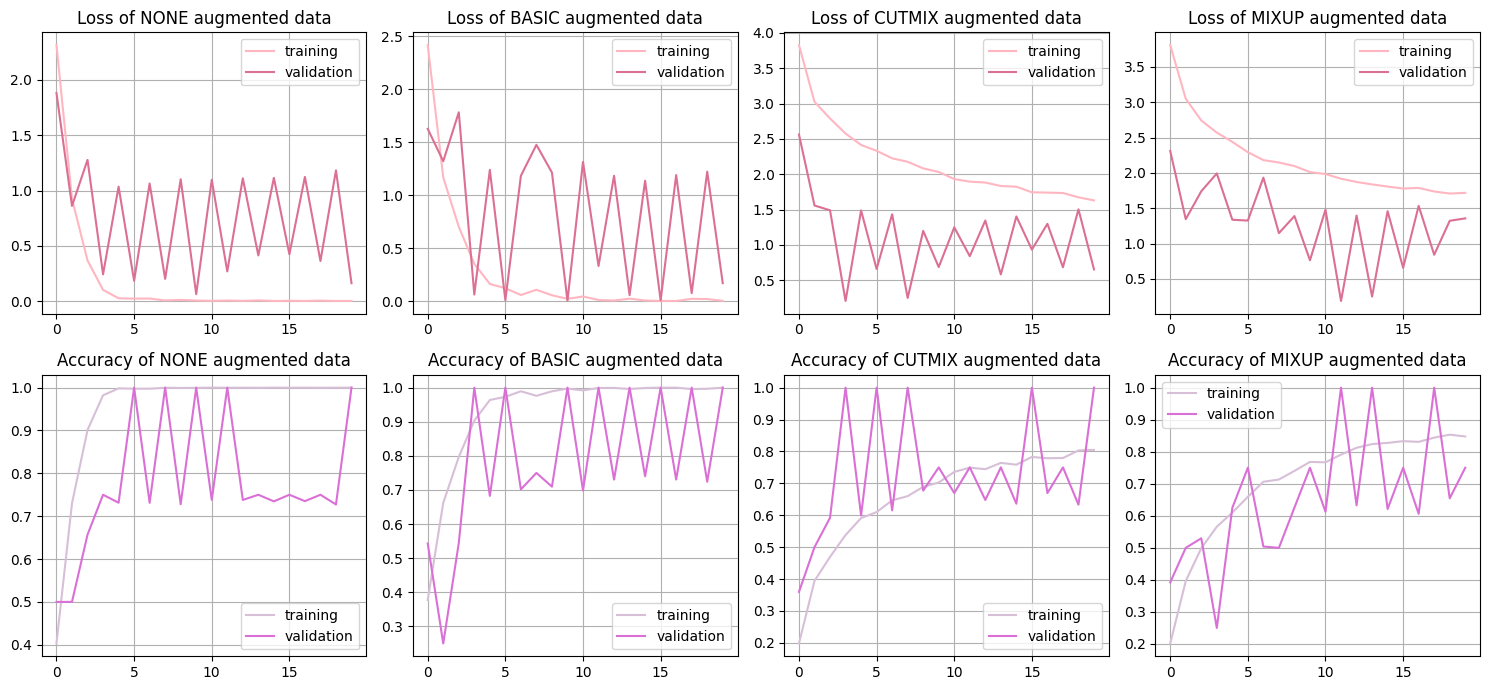

In [39]:
evaluate_4_augmentation(history_dict)

/tmp/ipykernel_265398/3486379982.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


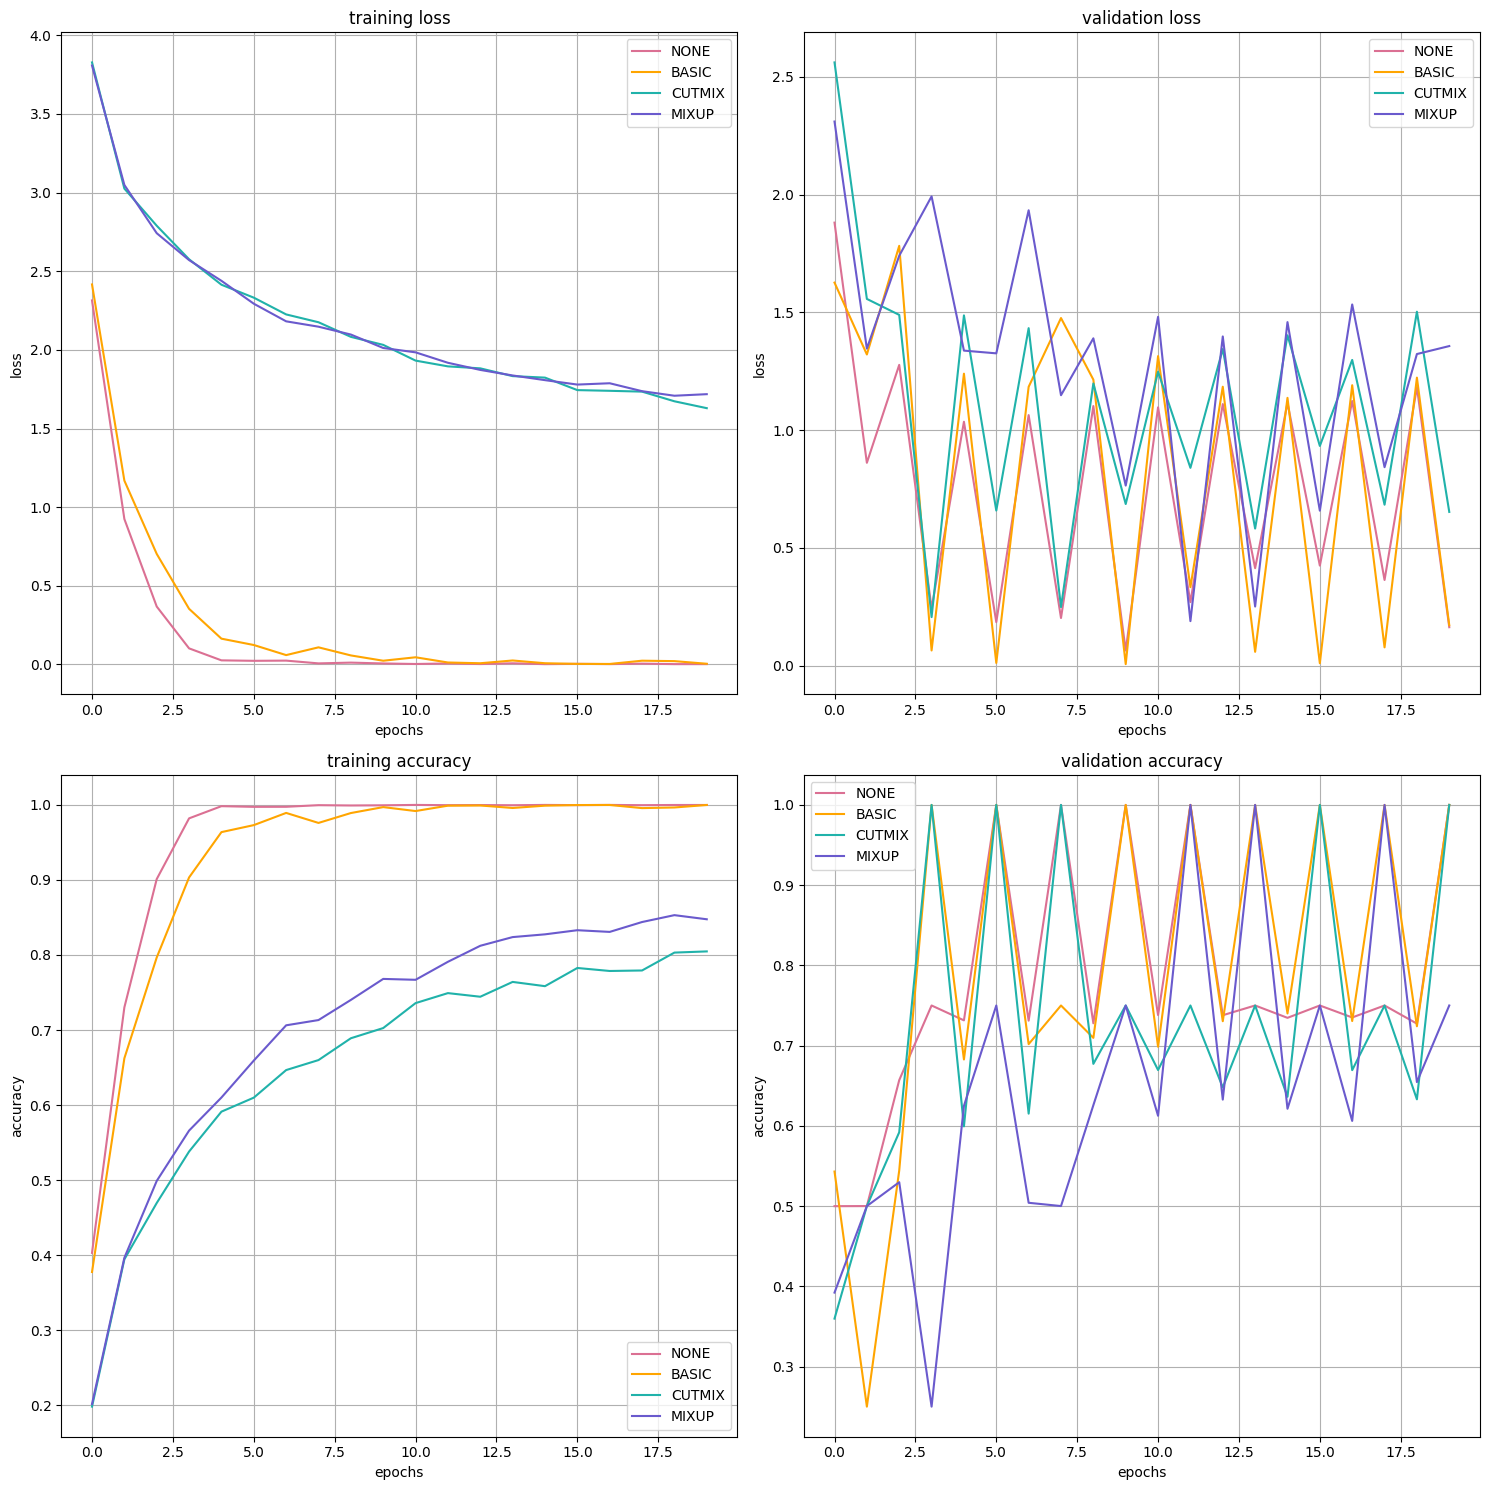

In [40]:
compare_4_augmentation(history_dict)

---
## <span style = "background-color: #FFFFDD"> 🐶 Conclusion</span>

**📝 실험결과 분석**
- 그래프상으로는 augmentation을 별도로 하지 않았을 때 training/test 경우 모두 loss와 accuracy 상관없이 가장 좋은 성능을 보였다.
- augmentation을 아예 하지 않거나 기본 augmentation을 적용했을 때 loss 및 accuracy 가 안정적으로 수렴하였다. 특히 EPOCHS=10 이후 시점부터는 training 성능은 변화가 거의 없고 validation 성능 또한 다소 불안정하나 큰 변화는 없었다.
- CutMix나 MixUp augmentation을 수행한 경우, 다른 경우에 비해 loss가 높고 EPOCHS=20 내내 점진적으로 하향되는 동향을 보였다. accuracy 또한 다른 경우에 비해 낮고, EPOCHS=20 내내 불안정하게 수치가 들쭉들쭉 변화하였으나 전반적으로는 상향하는 동향을 보였다.

**📝 회고록**  
- 이론상으로는 CutMix/MixUP augmentation을 적용하였을 때 더 나은 성능을 보여야 하는데, 실험에서는 완전히 반대되는 결과를 확인할 수 있었다. 해당 데이터셋의 경우 CutMix 및 MixUp augmentation이 효과적이지 못하거나, EPOCHS=20 수준으로 적은 학습을 수행했을 때 augmentation 효과가 잘 나타나지 않는 것일 수 있겠다.
- CutMix의 경우, 개와 전혀 상관없는 배경 부분이 합성되는 경우가 대다수였다. 즉 CutMix 수행 후에도 개의 품종에는 전혀 변화가 없는데(배경만 바뀌므로) 라벨은 CutMix 비율에 비례하여 변화되어버리니 오히려 학습에 방해가 될 수 있을 것이다. 본격적인 CutMix를 수행하려면 segmentation을 통해 "개" 객체에 해당하는 부분 위주로 합성할 영역을 선정하는 것이 좋을 것 같다.
- 프로젝트 난이도가 올라갈수록 모델 학습을 수행하는 대기 시간이 길어지는 것 같다. 이 시간을 효율적으로 사용할 수 있도록 새로운 개발 루틴이 필요하겠다 😄

---